In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array', max_episode_steps= 1000)

In [3]:
envs = gym.envs.registry
sorted(envs.keys())[:5] + ['...']

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', '...']

In [4]:
envs['CartPole-v1']

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [5]:
obs, info = env.reset(seed=0)

In [6]:
obs

array([ 0.01369617, -0.02302133, -0.04590265, -0.04834723], dtype=float32)

In [7]:
info

{}

In [8]:
img = env.render()
img.shape

(400, 600, 3)

In [9]:
def plot_envs(env):
    plt.figure(figsize= (5, 4))
    img = env.render()
    plt.imshow(img)
    plt.axis('off')
    return img


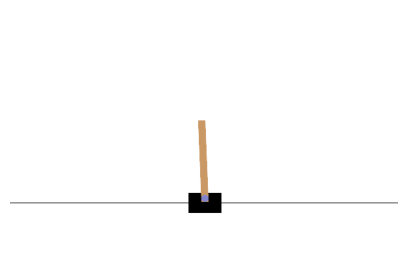

In [10]:
plot_envs(env)
plt.show()

In [15]:
env.action_space

Discrete(2)

In [11]:
action = 1
obs, rewards, done, truncated, info = env.step(action)

In [12]:
obs

array([ 0.01323574,  0.17272775, -0.04686959, -0.3551522 ], dtype=float32)

In [13]:
rewards, done, truncated, info

(1.0, False, False, {})

In [14]:
def policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    total_rewards = 0
    obs, info = env.reset(seed = episode)
    while True:
        action = policy(obs)
        obs, rewards, done, truncated, info = env.step(action)
        total_rewards += rewards
        if done or truncated:
            break
    totals.append(total_rewards)

In [15]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(np.float64(41.698), np.float64(8.389445512070509), 24.0, 63.0)

In [16]:
import matplotlib.animation
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array",
                   max_episode_steps=1000)
    obs, info = env.reset(seed=seed)
    while True:
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(policy)

In [20]:
from IPython.display import HTML
HTML(show_one_episode(policy).to_jshtml())

##### Neural Network Policies

In [17]:
class PolicyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 5),
            nn.ReLU(),
            nn.Linear(5,1)
        )
    def forward(self, state):
        return self.net(state)

In [18]:
def choose_action(model, obs):
    state = torch.as_tensor(obs)
    logit = model(state)
    dist = torch.distributions.Bernoulli(logits=logit)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return int(action.item()), log_prob

In [21]:
torch.manual_seed(42)
model = PolicyNN()
model.eval()

def nn_policy(obs):
    with torch.no_grad():
        action, _ = choose_action(model, obs)
        return action
HTML(show_one_episode(nn_policy).to_jshtml())

In [22]:
def compute_returns(rewards, discount_factor):
    returns = rewards[:]
    for step in range(len(rewards) -1, 0, -1):
        returns[step - 1] += returns[step] * discount_factor
    return torch.tensor(returns)

In [23]:
compute_returns([10, 0, -50], discount_factor= 0.8)

tensor([-22., -40., -50.])

In [24]:
def run_episodes(model, env,  seed= None):
    log_probas, rewards = [], []
    obs, info = env.reset(seed=seed)
    while True:
        action, log_prob = choose_action(model, obs)
        obs, reward, done, truncated, info = env.step(action)
        log_probas.append(log_prob)
        rewards.append(reward)
        if done or truncated:
            return log_probas, rewards

In [25]:
def train_reinforce(model, optimizer, env, n_episodes, discount_factor):
    for episode in range(n_episodes):
        seed = torch.randint(0, 2 ** 32, size= ()).item()
        log_probs, rewards = run_episodes(model, env, seed)
        returns = compute_returns(rewards, discount_factor)
        std_returns = (returns - returns.mean()) / (returns.std() + 1e-7)
        losses = [-logp * rt for logp, rt in zip(log_probs, std_returns)]
        loss = torch.cat(losses).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'\rEpisode {episode + 1}, Reward: {sum(rewards):.2f}', end='')

In [26]:
torch.manual_seed(42)
model = PolicyNN()
optimizer = torch.optim.NAdam(model.parameters(), lr = 0.06)
train_reinforce(model, optimizer, env, n_episodes= 200, discount_factor= 0.9)

Episode 200, Reward: 458.000

In [27]:
HTML(show_one_episode(nn_policy).to_jshtml())

##### Q Value Iteration

In [28]:
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [29]:
Q_values = np.full((3 , 3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state, action] = 0.0

In [30]:
gamma = 0.9
history1 = []

for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * Q_prev[sp].max()) for sp in range(3)])
history1 = np.array(history1)

In [31]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [34]:
Q_values.argmax(axis= 1)

array([0, 0, 1])